### Adicionando dependencias

In [1]:
import nltk.translate.bleu_score as bleu
import nltk.translate.gleu_score as gleu
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LinearRegression
%matplotlib inline

### Adicionando função para avaliar o wer_score

In [2]:
def wer_score(hyp, ref, print_matrix=False):
  N = len(hyp)
  M = len(ref)
  L = np.zeros((N,M))
  for i in range(0, N):
    for j in range(0, M):
      if min(i,j) == 0:
        L[i,j] = max(i,j)
      else:
        deletion = L[i-1,j] + 1
        insertion = L[i,j-1] + 1
        sub = 1 if hyp[i] != ref[j] else 0
        substitution = L[i-1,j-1] + sub
        L[i,j] = min(deletion, min(insertion, substitution))
        # print("{} - {}: del {} ins {} sub {} s {}".format(hyp[i], ref[j], deletion, insertion, substitution, sub))
  if print_matrix:
    print("WER matrix ({}x{}): ".format(N, M))
    print(L)
  return int(L[N-1, M-1])

### Adicionando função para visualizar resultados

In [3]:
def plotData(history, title, log = False, x = None, size = None, regression = False):
    sz = size
    if sz is None:
        sz = len(history)
    plt.figure(figsize = (13,7))
    
    y = history[0:sz]
    if log:
        y = -np.log(y)
    if x is None:
        x = np.arange(0, sz)
    if regression:
        y_temp = y.reshape(-1,1)
        x_temp = x.reshape(-1,1)
        reg = LinearRegression()
        reg.fit(x_temp, y_temp)
        lin_x = np.linspace(0,sz-1).reshape(-1,1)
        lin_y = reg.predict(lin_x)
        plt.plot(lin_x, lin_y, '--', linewidth = 1, color = 'purple')
    
    plt.plot(x, y, marker = 'o', markerfacecolor = 'purple',
             linewidth = 3, markersize = 4.5, color = 'coral')
    plt.title(title)
    plt.xlabel('Iterações')
    if log:
        plt.ylabel('-log[Pontuação]')
    else:
        plt.ylabel('Pontuação')
    #plt.grid()
    plt.show()

### Trabalhando sobre o .json *high*

In [4]:
file = open('results/idh_high_2019_09_02_monit.json', 'r')
base = json.load(file)
file.close()

#### Avaliação do .json **acumulado**

In [5]:
sz = len(base)
gleu_hist = []
#bleu_hist = []
#wer_hist = []

reference = base[0]['Text_en']

for i in range(0, sz):
    hypothesis = base[i]['Text_en']
    gleu_hist.append(gleu.sentence_gleu([reference], hypothesis))
    #bleu_hist.append(bleu.sentence_bleu([reference], hypothesis))
    #wer_hist.append(wer_score(hypothesis.split(), reference.split(), print_matrix = False))
    
gleu_hist_acc_high = np.asarray(gleu_hist)
#bleu_hist = np.asarray(bleu_hist)
#wer_hist = np.asarray(wer_hist)

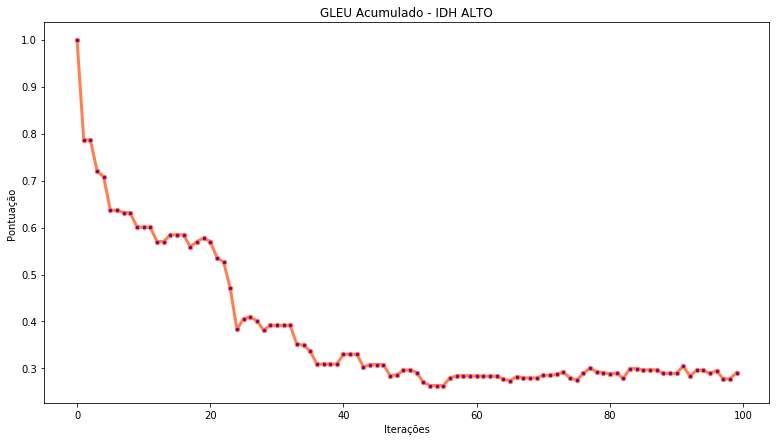

In [6]:
plotData(gleu_hist_acc_high, 'GLEU Acumulado - IDH ALTO')

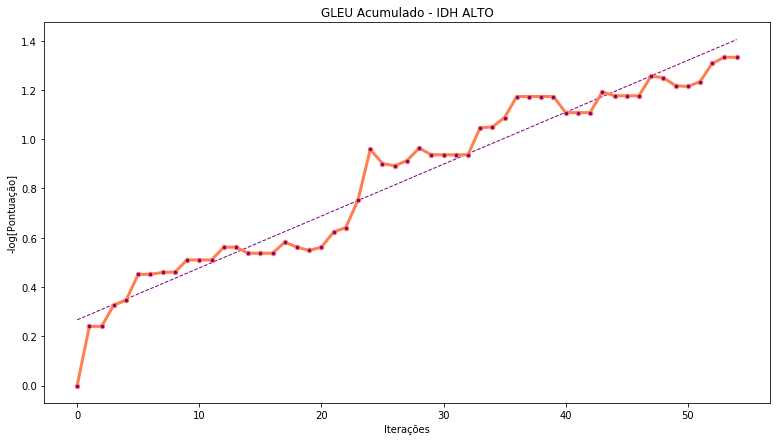

In [7]:
plotData(gleu_hist_acc_high, 'GLEU Acumulado - IDH ALTO', log = True, size = 55, regression = True)

#### Avaliação do .json **passo a passo**

In [8]:
sz = len(base)
gleu_hist = []
x = []

for i in range(sz-1):
    reference = base[i]['Text_en']
    hypothesis = base[i+1]['Text_en']
    gleu_score = gleu.sentence_gleu([reference], hypothesis)
    if gleu_score == 1.0:
        continue
    gleu_hist.append(gleu.sentence_gleu([reference], hypothesis))
    x.append(i)
    
gleu_hist_pp_high = np.asarray(gleu_hist)

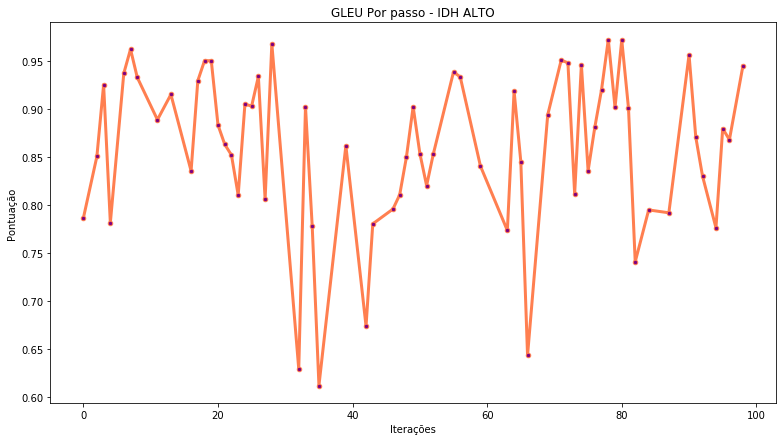

In [9]:
plotData(gleu_hist_pp_high, 'GLEU Por passo - IDH ALTO', log = False, x = x)

### Trabalhando sobre o .json *low*

In [10]:
file = open('results/idh_low_2019_09_02_monit.json', 'r')
base = json.load(file)
file.close()

#### Avaliação do .json **acumulado**

In [11]:
sz = len(base)
gleu_hist = []

reference = base[0]['Text_en']

for i in range(0, sz):
    hypothesis = base[i]['Text_en']
    gleu_hist.append(gleu.sentence_gleu([reference], hypothesis))
    
gleu_hist = np.asarray(gleu_hist)

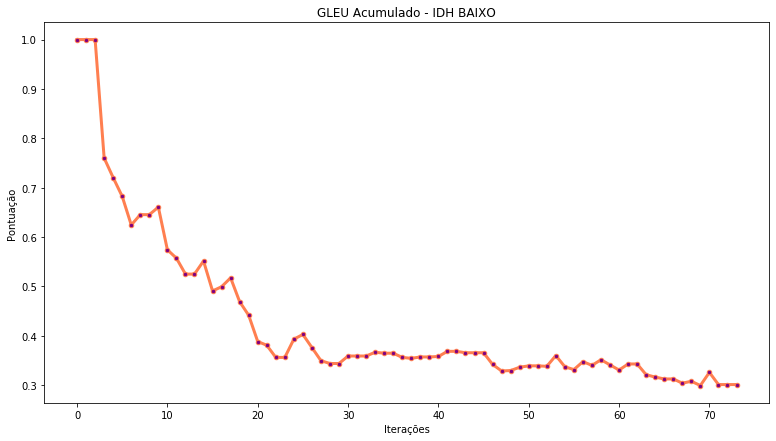

In [12]:
plotData(gleu_hist, 'GLEU Acumulado - IDH BAIXO')

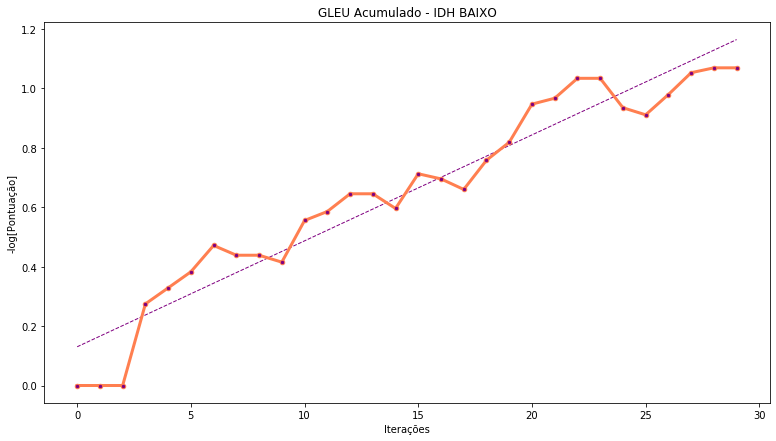

In [13]:
plotData(gleu_hist, 'GLEU Acumulado - IDH BAIXO', size = 30, log = True, regression = True)

#### Avaliação do .json **passo a passo**

In [14]:
sz = len(base)
gleu_hist = []
x = []

for i in range(sz-1):
    reference = base[i]['Text_en']
    hypothesis = base[i+1]['Text_en']
    gleu_score = gleu.sentence_gleu([reference], hypothesis)
    if gleu_score == 1.0:
        continue
    gleu_hist.append(gleu.sentence_gleu([reference], hypothesis))
    x.append(i)

gleu_hist = np.asarray(gleu_hist)

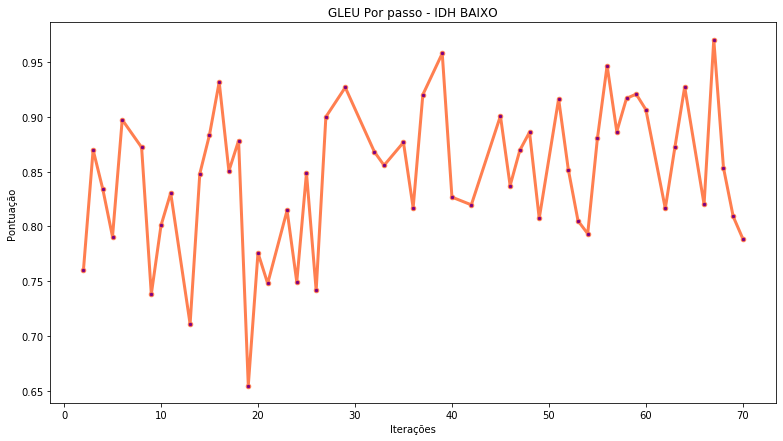

In [15]:
plotData(gleu_hist, 'GLEU Por passo - IDH BAIXO', log = False, x = x)